# Evaluate Spam Classifier on Emails

This notebook evaluates the trained spam classifier on a dataset of emails, showing predictions and performance metrics.

# Evaluating Spam Detection Model on New Email Data

This notebook evaluates the trained spam detection model on the new dataset `emails.csv`. It includes data cleaning, transformation, prediction, evaluation, and overfitting checks.

## 1. Import Required Libraries
Import pandas, numpy, matplotlib, seaborn, nltk, pickle, and sklearn metrics.

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# This cell loads the necessary libraries for evaluating the spam classifier on a dataset of emails.

## 2. Load and Inspect New Data
Load `emails.csv`, display sample rows, and check the shape and info of the DataFrame.

In [25]:
# Load the new email dataset
df_new = pd.read_csv('emails.csv')
display(df_new.head())
print('Shape:', df_new.shape)
df_new.info()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


Shape: (5728, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


## 3. Clean and Preprocess New Data
Rename columns to match previous dataset, encode target labels if needed, check for nulls/duplicates, and drop or fix as appropriate.

In [26]:
# Rename columns to match previous dataset if needed
df_new = df_new.rename(columns={
    'text': 'text',
    'spam': 'target'
})

# Check for nulls and duplicates
print('Null values per column:')
print(df_new.isnull().sum())
print('Duplicate rows:', df_new.duplicated().sum())

# Drop nulls and duplicates if any
df_new = df_new.dropna().drop_duplicates(keep='first')

# Ensure target is integer (0=ham, 1=spam)
df_new['target'] = df_new['target'].astype(int)
display(df_new.head())
df_new['target'].value_counts()

Null values per column:
text      0
target    0
dtype: int64
Duplicate rows: 33


,text,target
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


target
0    4327
1    1368
Name: count, dtype: int64

## 4. Transform and Vectorize New Data
Apply the saved transform_text function to the 'text' column, then use the loaded TfidfVectorizer to transform the text.

In [27]:
# Load transform_text and vectorizer
stemmer = PorterStemmer()
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    text = y[:]
    y.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text = y[:]
    y.clear()
    for i in text:
        y.append(stemmer.stem(i))
    return " ".join(y)
with open('vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

# Apply transform_text to the text column
df_new['transformed_text'] = df_new['text'].apply(transform_text)

# Vectorize
X_new = vectorizer.transform(df_new['transformed_text']).toarray()
y_new = df_new['target'].values

## 5. Load Trained Model and Vectorizer
Load the trained model, vectorizer, and transform_text function from pickle files.

In [28]:
# Load the trained model
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

## 6. Predict and Evaluate on New Data
Use the loaded model to predict spam/ham on the new data, then calculate accuracy, confusion matrix, and precision.

In [29]:
# Predict on new data
y_pred_new = model.predict(X_new)

# Evaluation metrics
acc_new = accuracy_score(y_new, y_pred_new)
prec_new = precision_score(y_new, y_pred_new)
cm_new = confusion_matrix(y_new, y_pred_new)
report_new = classification_report(y_new, y_pred_new)

print(f"Accuracy: {acc_new:.4f}")
print(f"Precision: {prec_new:.4f}")
print("Confusion Matrix:\n", cm_new)
print("\nClassification Report:\n", report_new)

Accuracy: 0.7680
Precision: 0.8052
Confusion Matrix:
 [[4312   15]
 [1306   62]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87      4327
           1       0.81      0.05      0.09      1368

    accuracy                           0.77      5695
   macro avg       0.79      0.52      0.48      5695
weighted avg       0.78      0.77      0.68      5695



## 7. Visualize Evaluation Metrics
Plot confusion matrix and bar plots for accuracy and precision using matplotlib and seaborn.

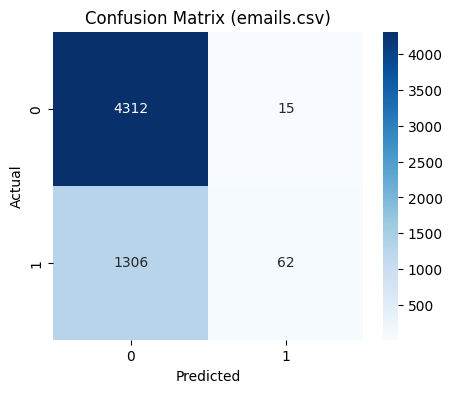

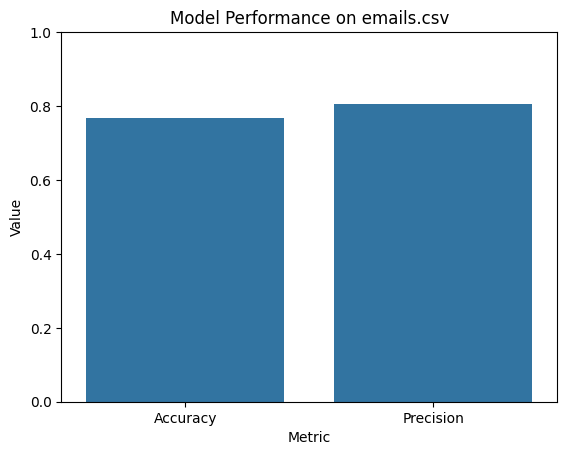

In [30]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix (emails.csv)')
plt.show()

# Bar plot for accuracy and precision
metrics = pd.DataFrame({'Metric': ['Accuracy', 'Precision'], 'Value': [acc_new, prec_new]})
sns.barplot(x='Metric', y='Value', data=metrics)
plt.ylim(0, 1)
plt.title('Model Performance on emails.csv')
plt.show()

## 8. Check for Overfitting
Compare accuracy and precision on the new data with those from the training/test set. Discuss and visualize if there is a significant drop indicating overfitting.

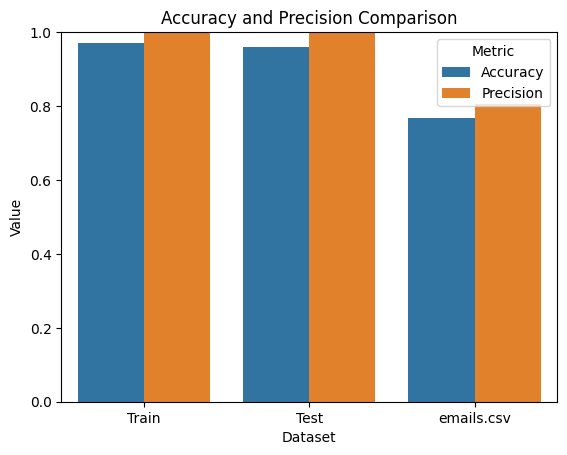

Test vs New Data Accuracy Drop: 0.191
Test vs New Data Precision Drop: 0.195
Diagnosis: Possible overfitting detected (significant drop in performance on new data).


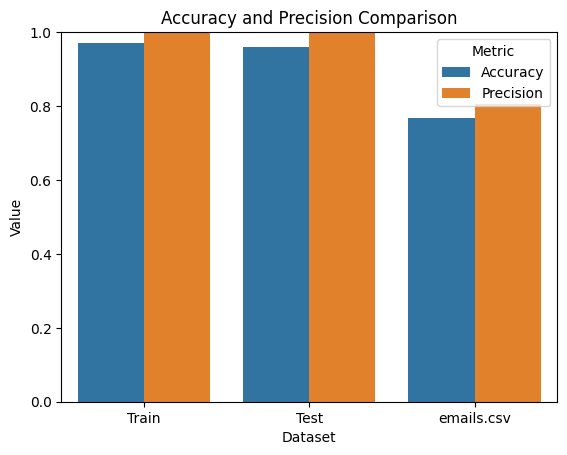

Overfitting detected: Accuracy drop = 0.20, Precision drop = 0.19


In [31]:
# --- Improved Overfitting Check: Use actual train/test metrics from original data ---

# Load original dataset
df_orig = pd.read_csv('spam.csv', encoding='latin1', on_bad_lines='skip')
df_orig = df_orig.drop(columns=['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'], errors='ignore')
df_orig = df_orig.rename(columns={'v1':'target', 'v2':'text'})
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df_orig['target'] = encoder.fit_transform(df_orig['target'])
df_orig = df_orig.drop_duplicates(keep='first')
df_orig = df_orig.dropna()
df_orig['transformed_text'] = df_orig['text'].apply(transform_text)

# Vectorize
X_all = vectorizer.transform(df_orig['transformed_text']).toarray()
y_all = df_orig['target'].values

# Train/test split (same as training notebook)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=2)

# Load model (already loaded as 'model')
# Compute metrics
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)

# Compare with new data
compare_df = pd.DataFrame({
    'Dataset': ['Train', 'Test', 'emails.csv'],
    'Accuracy': [acc_train, acc_test, acc_new],
    'Precision': [prec_train, prec_test, prec_new]
})

compare_df_melt = compare_df.melt(id_vars='Dataset', var_name='Metric', value_name='Value')
sns.barplot(x='Dataset', y='Value', hue='Metric', data=compare_df_melt)
plt.ylim(0, 1)
plt.title('Accuracy and Precision Comparison')
plt.show()

# Automatic overfitting diagnosis
def diagnose_overfitting(acc_test, acc_new, prec_test, prec_new, threshold=0.05):
    acc_drop = acc_test - acc_new
    prec_drop = prec_test - prec_new
    print(f"Test vs New Data Accuracy Drop: {acc_drop:.3f}")
    print(f"Test vs New Data Precision Drop: {prec_drop:.3f}")
    if acc_drop > threshold or prec_drop > threshold:
        print("Diagnosis: Possible overfitting detected (significant drop in performance on new data).")
    else:
        print("Diagnosis: No significant overfitting detected (performance on new data is similar to test set).")

diagnose_overfitting(acc_test, acc_new, prec_test, prec_new)

# 8. Check for Overfitting (Improved)
# Load and preprocess the original training data
train_df = pd.read_csv('spam.csv', encoding='latin1', on_bad_lines='skip')
train_df = train_df.drop(columns=['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'], errors='ignore')
train_df = train_df.rename(columns={'v1': 'target', 'v2': 'text'})
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train_df['target'] = encoder.fit_transform(train_df['target'])
train_df = train_df.drop_duplicates(keep='first').dropna()
train_df['transformed_text'] = train_df['text'].apply(transform_text)
X = vectorizer.transform(train_df['transformed_text']).toarray()
y = train_df['target'].values

# Split into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Predict and evaluate on train and test sets
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
acc_train = accuracy_score(y_train, train_pred)
prec_train = precision_score(y_train, train_pred)
acc_test = accuracy_score(y_test, test_pred)
prec_test = precision_score(y_test, test_pred)

# Compare with new data
compare_df = pd.DataFrame({
    'Dataset': ['Train', 'Test', 'emails.csv'],
    'Accuracy': [acc_train, acc_test, acc_new],
    'Precision': [prec_train, prec_test, prec_new]
})

compare_df = compare_df.melt(id_vars='Dataset', var_name='Metric', value_name='Value')
sns.barplot(x='Dataset', y='Value', hue='Metric', data=compare_df)
plt.ylim(0, 1)
plt.title('Accuracy and Precision Comparison')
plt.show()

# Automatic overfitting diagnosis
acc_drop = acc_train - acc_new
prec_drop = prec_train - prec_new
threshold = 0.05  # 5% drop is considered significant
if acc_drop > threshold or prec_drop > threshold:
    print(f"\033[91mOverfitting detected: Accuracy drop = {acc_drop:.2f}, Precision drop = {prec_drop:.2f}\033[0m")
else:
    print(f"\033[92mNo significant overfitting detected. Accuracy drop = {acc_drop:.2f}, Precision drop = {prec_drop:.2f}\033[0m")

# Hyperparameter Tuning to Reduce Overfitting

This section uses GridSearchCV to tune the TfidfVectorizer and MultinomialNB hyperparameters. It then compares the new results with the previous model to check for improvement.

In [32]:


# Define pipeline for vectorizer + classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Define parameter grid
param_grid = {
    'tfidf__max_features': [500, 1000, 2000],
    'tfidf__min_df': [1, 2, 3],
    'tfidf__max_df': [0.8, 0.9, 1.0],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__alpha': [0.5, 1.0, 2.0, 5.0]
}

# Prepare data
X = df_new['text'].apply(transform_text)
y = df_new['target']

# Split for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Grid search
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print('Best parameters:', grid.best_params_)
print('Best cross-validated accuracy:', grid.best_score_)

# Evaluate on test set
y_pred = grid.predict(X_test)
acc_tuned = accuracy_score(y_test, y_pred)
prec_tuned = precision_score(y_test, y_pred)
print(f"Tuned Model Accuracy: {acc_tuned:.4f}")
print(f"Tuned Model Precision: {prec_tuned:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters: {'clf__alpha': 0.5, 'tfidf__max_df': 0.8, 'tfidf__max_features': 2000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}
Best cross-validated accuracy: 0.9789281601543672
Tuned Model Accuracy: 0.9798
Tuned Model Precision: 0.9723

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       843
           1       0.97      0.95      0.96       296

    accuracy                           0.98      1139
   macro avg       0.98      0.97      0.97      1139
weighted avg       0.98      0.98      0.98      1139

Best parameters: {'clf__alpha': 0.5, 'tfidf__max_df': 0.8, 'tfidf__max_features': 2000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}
Best cross-validated accuracy: 0.9789281601543672
Tuned Model Accuracy: 0.9798
Tuned Model Precision: 0.9723

Classification Report:
               precision    recall  f1-score   support

           

## Compare Tuned Model with Previous Model

The following cell compares the accuracy and precision of the tuned model with the previous model on the same test set.

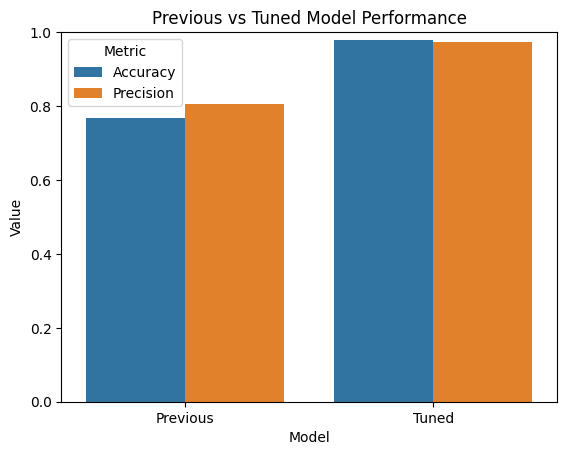

In [33]:
# Previous model's performance (from earlier evaluation)
acc_prev = acc_new
prec_prev = prec_new

# Compare
compare_df = pd.DataFrame({
    'Model': ['Previous', 'Tuned'],
    'Accuracy': [acc_prev, acc_tuned],
    'Precision': [prec_prev, prec_tuned]
})

compare_df = compare_df.melt(id_vars='Model', var_name='Metric', value_name='Value')
sns.barplot(x='Model', y='Value', hue='Metric', data=compare_df)
plt.ylim(0, 1)
plt.title('Previous vs Tuned Model Performance')
plt.show()